## Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import pandas as pd
from PIL import Image
import argparse
import cv2
import logging
import librosa
import numpy as np
import subprocess

from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear, ExtractIntermediateLayerForGradcam
from tf_keras_vis.utils.scores import CategoricalScore

In [2]:
MODEL_PATH = {
    "model_pre" : "./model_inferences/cochldb.2.15.230316_v8_22050_Ensemble_Distill_cochldb.2.15.230316_v8_Ensemble_Distill_22050_model_pre.h5",
    "Ensemble_Distill" : "./model_inferences/cochldb.2.15.230316_v8_22050_Ensemble_Distill_cochldb.2.15.230316_v8_Ensemble_Distill_22050_result_230615-test_model_main.h5",
    "SEResNet" : "./model_inferences/cochldb.2.15.230316_v8_22050_Single_cochldb.2.15.230316_v8_Single_SEResNetLowPool_22050_aug_model_main.h5",
    "Xception" : "./model_inferences/cochldb.2.15.230316_v8_22050_Single_cochldb.2.15.230316_v8_Single_Xception_22050_aug_model_main.h5",
    "MobileNetSpecAug" : "./model_inferences/cochldb.2.16.230425_v4_cochldb.2.16.230425_v4_MobileNetV2_11221306_model_main.h5",
}

### Pre 모델 불러오기

In [6]:
model_pre = keras.models.load_model("./model_inferences/cochldb.2.15.230316_v8_22050_Ensemble_Distill_cochldb.2.15.230316_v8_Ensemble_Distill_22050_model_pre.h5", compile=False)

### Cochl 모델 불러오는 경우의 수

In [7]:
# "Ensemble_Distill" or "SEResNetLowPool" or "Xception"
MODEL_TYPE = "Ensemble_Distill"

In [201]:
# Functional 구조의 Main-model (higher Complexity)
model_main = keras.models.load_model(MODEL_PATH["Ensemble_Distill"], compile=False)

In [446]:
# model Xception
model_main = keras.models.load_model(MODEL_PATH["Xception"], compile=False)

/Users/jwyeeh/miniforge3/envs/Cochl/lib/python3.8/site-packages/keras/src/layers/core/lambda_layer.py:327: UserWarning: EATS.model_utils.networks is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


In [222]:
# model SEResNet
model_main = keras.models.load_model(MODEL_PATH["SEResNet"], compile=False)

/Users/jwyeeh/miniforge3/envs/Cochl/lib/python3.8/site-packages/keras/src/layers/core/lambda_layer.py:327: UserWarning: EATS.model_utils.networks is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


In [8]:
# model MobileNetV2 with Spec Augmentation
model_main = keras.models.load_model(MODEL_PATH["MobileNetSpecAug"], compile=False)

In [202]:
inner_model_2 = model_main.get_layer('model_2')
inner_reduce_model_0 = model_main.get_layer('model_2').get_layer('reduced_model_0')
inner_reduce_model_1 = model_main.get_layer('model_2').get_layer('reduced_model_1')
inner_model_0 = model_main.get_layer('model_2').get_layer('reduced_model_0').get_layer('model')
inner_model_1 = model_main.get_layer('model_2').get_layer('reduced_model_1').get_layer('model_1')


### 모델 입력 변환 (Extract Audio from Video)

In [61]:
def extract_audio(input_file, output_file = './extracted_audio.mp3'):
    
    cmd = [
        'ffmpeg',
        '-i', input_file,
        '-vn',
        output_file
    ]
    
    subprocess.run(cmd, text=True)

    return output_file

### Mel-spectrogram with Librosa

In [10]:
def mel_spec_with_librosa(AUDIO_PATH):
    y, sr = librosa.load(AUDIO_PATH, sr=22050)  # 로드 시 샘플링 레이트를 22050으로 설정
    print(y.shape)
    # 1초 단위로 나눔
    frames = librosa.util.frame(y, frame_length=22050, hop_length=22050).T
    print(frames.shape)
    # 모델 입력을 위해 적절한 형태로 변환
    frames_reshaped = frames.reshape(frames.shape[0], 1, 22050)
    print(frames_reshaped.shape)
    return y, sr, frames_reshaped

### 모델 입력 로드

In [198]:
# Audio 정보 관련 변수
DELAY_TIME = 0.7
FRONT_TIME = 0.3
MIDDLE_TIME = 0.2
CLASS_NAME = "siren"
EXPECTED_PROB = 90
PF_TYPE = "lpf"
PF_FREQ = 1000
PF_ROLLOFF = 0.5

In [199]:
# WAV 파일 경로 규격화
AUDIO_PATH = f"./dataset/{CLASS_NAME}/{CLASS_NAME}_prob_{EXPECTED_PROB}_delay_{DELAY_TIME}.wav"
#AUDIO_PATH = f"./dataset/{CLASS_NAME}/{CLASS_NAME}_prob_{EXPECTED_PROB}_front_{FRONT_TIME}_delay_{DELAY_TIME}.wav"
#AUDIO_PATH = f"./dataset/{CLASS_NAME}/{CLASS_NAME}_prob_{EXPECTED_PROB}_mid_{MIDDLE_TIME}.wav"
#AUDIO_PATH = f"./dataset/{CLASS_NAME}/{CLASS_NAME}_prob_{EXPECTED_PROB}.wav"

In [200]:
y, sr, frames_reshaped = mel_spec_with_librosa(AUDIO_PATH)

(25210,)
(1, 22050)
(1, 1, 22050)


## Pre-Model 투입

### Merged Tags (104 classes)

In [437]:
tags = pd.read_csv('./model_inferences/cochldb.tags.csv')
print(tags)

                tags
0     Aircraft_noise
1              Alarm
2           Applause
3    Appliance_alarm
4           Baby_cry
..               ...
99           Whistle
100       Wind_noise
101             Yawn
102             Yell
103           Others

[104 rows x 1 columns]


### Total Tags (752 classes)

In [23]:
tags = pd.read_csv('./model_inferences/cochldb.tags.orig.csv')
print(tags)

                           tags
0                     Acappella
1    Accelerating_revving_vroom
2                      Accident
3                     Accordion
4               Acoustic_guitar
..                          ...
747                     Writing
748                        Yawn
749                        Yell
750           Zipper_(clothing)
751                      Others

[752 rows x 1 columns]


### Cochldb.2.16.230425_v4 (772 classes)

In [98]:
tags = pd.read_csv('./model_inferences/cochldb.2.16.230425_v4_cochldb.2.16.230425_v4_MobileNetV2_11221306_event_classes.csv')
print(tags)

                           tags
0                     Acappella
1    Accelerating_revving_vroom
2                      Accident
3                    Accordionß
4               Acoustic_guitar
..                          ...
767           Wrench_or_spanner
768                     Writing
769                        Yawn
770           Zipper_(clothing)
771                      Others

[772 rows x 1 columns]


### Ensenble_Distill, SEResnet50, Xception Model

In [223]:
# 모델에 입력
most_predicted = []
model_outputs = []

# 0th : model_pre
model_pre_output = model_pre.predict(frames_reshaped)

# 1st : model_main
predicted_labels = model_main.predict(model_pre_output)
probabilities = predicted_labels[0][83]
pred_class_num = predicted_labels.argmax()
pred_class_name = tags['tags'][pred_class_num] 

1/1 [==============================] - 1s 974ms/step


In [225]:
# ------------------ RESULT ------------------
print("="*20 + "RESULT" + "="*20)
print(f"probability            | {probabilities}")
print(f"predicted_class_number | {pred_class_num}")
print(f"predicted_class        | {tags['tags'][]}")
print("="* 46)

====================RESULT====================
probability            | 0.00015232920122798532
predicted_class_number | 275
predicted_class        | Bounce


## Mel-Spectrogram 시각화

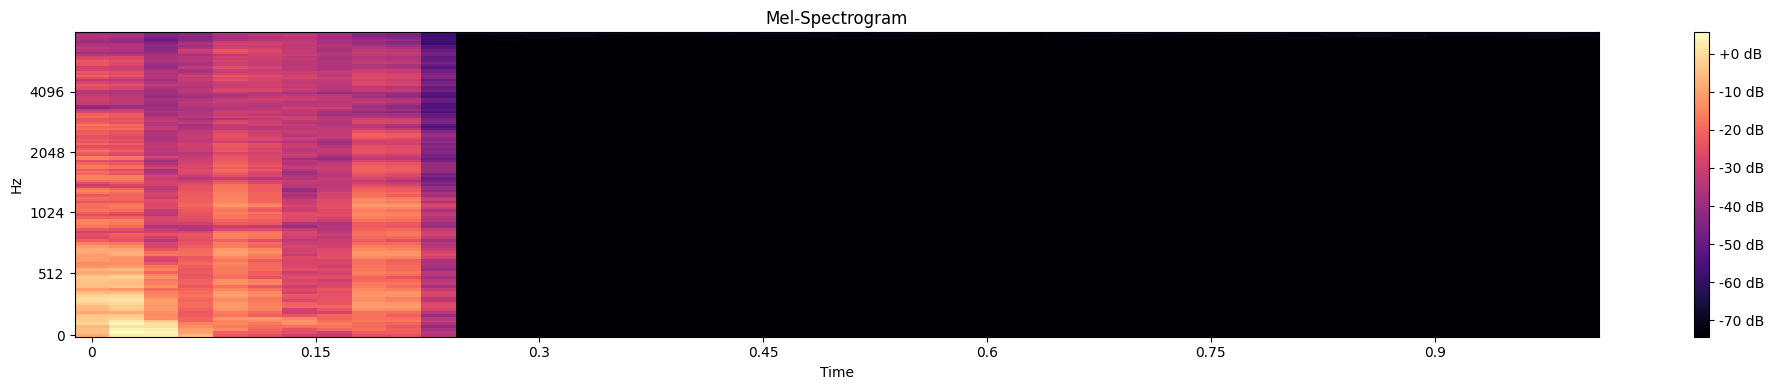

In [139]:
# librosa mel-spectrogram visualization
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# plot mel-spectrogram of audio
plt.figure(figsize=(20, 4))
librosa.display.specshow(librosa.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.show()


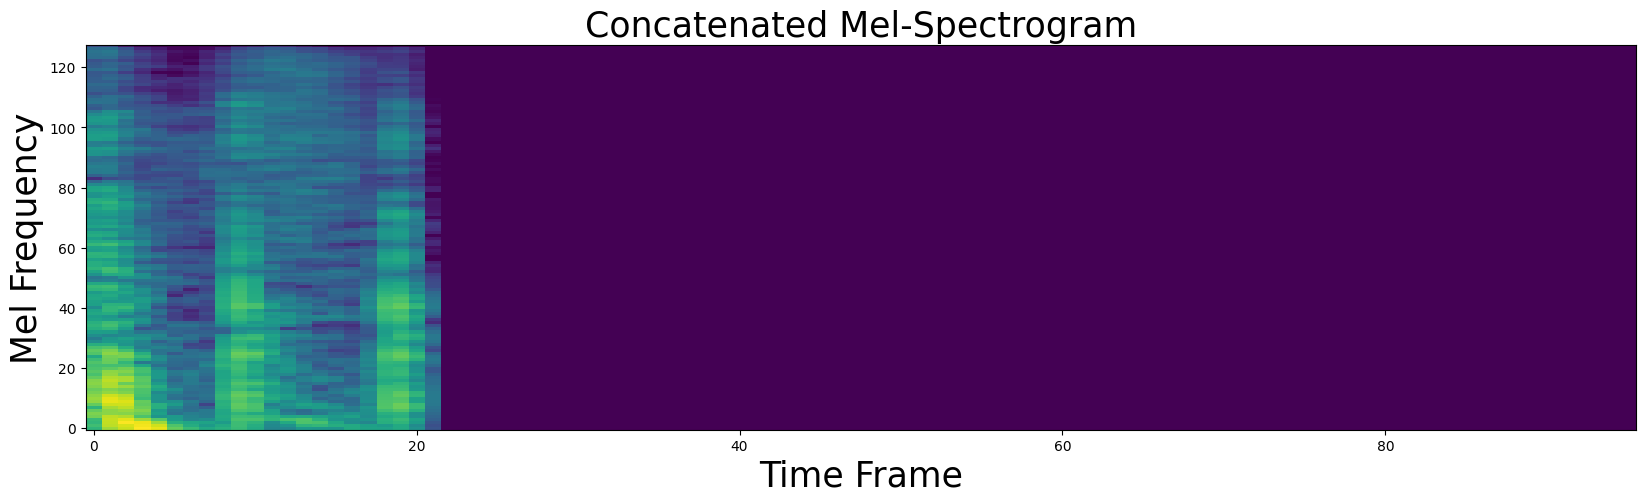

In [140]:
import matplotlib.pyplot as plt
import numpy as np


mel_spectrogram = np.concatenate(model_pre_output, axis=1)

plt.figure(figsize=(20, 5)) 
plt.imshow(mel_spectrogram, aspect='auto', origin='lower')
plt.title('Concatenated Mel-Spectrogram', fontsize=25)
plt.ylabel('Mel Frequency', fontsize=25)
plt.xlabel('Time Frame', fontsize=25)
#plt.colorbar(format='%+02.0f dB')
plt.show()


### Parameter Setup

In [82]:
LAYERS = [
'conv2d_46', 'm_main_0_Conv_1', 'm_main_1_Conv_1', 'block14_sepconv1', 'Conv_1',
]

LAYER_NAME0 = LAYERS[1]
LAYER_NAME1 = LAYERS[2]
LAYER_NAME2 = LAYERS[0]
LAYER_NAME3 = LAYERS[3]
LAYER_NAME4 = LAYERS[4]


In [206]:
grids = []
grids1 = []

# GradCAM을 적용합니다.
for i in range(model_pre_output.shape[0]):
    
    model_data = np.expand_dims(model_pre_output[i], axis=0)

    # Create GradCAM

    gradcam = Gradcam(inner_model_0, model_modifier=ReplaceToLinear(), clone=True)
    gradcam = Gradcam(inner_model_1, model_modifier=ReplaceToLinear(), clone=True)
    
    # Generate heatmap with GradCAM

    data = (model_data, None)
    cam = gradcam(CategoricalScore(pred_class_num), model_data)
    cam1 = gradcam(CategoricalScore(pred_class_num), model_data)

    # Render
    grids.append(cam)
    grids1.append(cam1)
    


### About 1sec

Text(0.5, 0, 'Time Frame : 1sec')

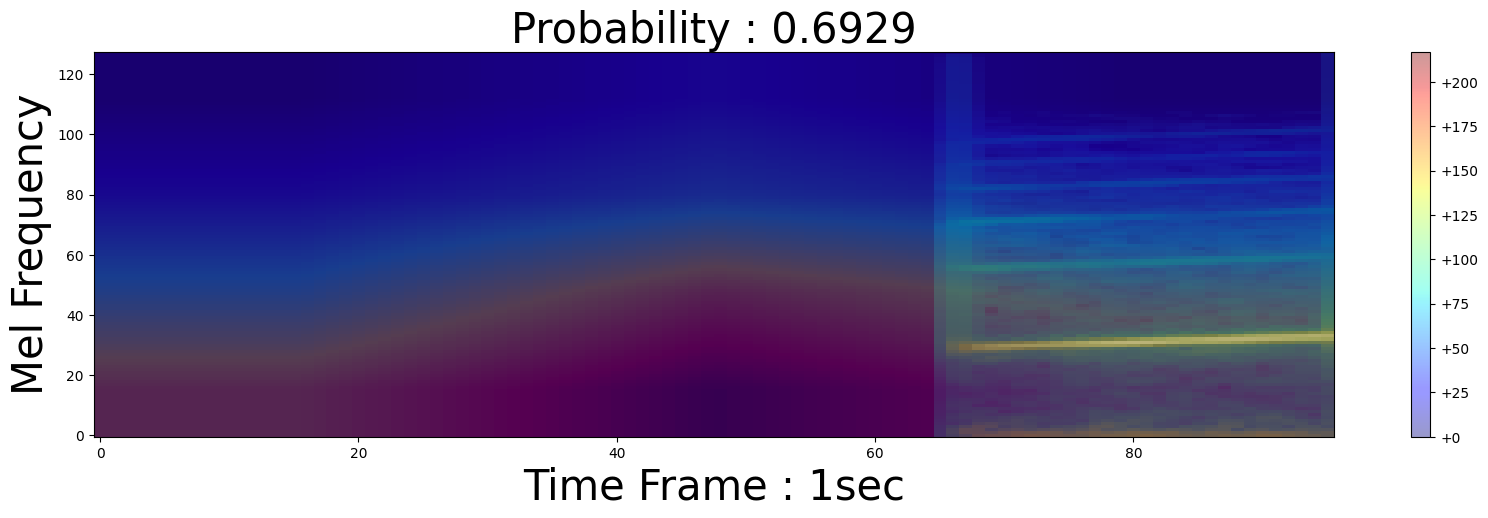

In [221]:
#grids[0] = grids[0].reshape(128,96,1)
#grids1[0] = grids1[0].reshape(128,96,1)
plt.figure(figsize=(20, 5))
plt.imshow(model_pre_output[0], aspect='auto', origin='lower')
plt.imshow(grids[0][:,:], alpha=0.4, aspect='auto', origin='lower', cmap='jet')
plt.imshow(grids1[0][:,:], alpha=0.4, aspect='auto', origin='lower', cmap='jet')
plt.colorbar(format='%+02.0f')
plt.title(f'Probability : {probabilities:.4f}', fontsize=30)
plt.ylabel('Mel Frequency', fontsize=30)
plt.xlabel(f'Time Frame : 1sec', fontsize=30)

### Visualizing Functions


In [ ]:

def plot_grad_cam(model_pre_output, grids, grids1):

    fig, axs = plt.subplots(2,5, figsize=(50, 35), facecolor='w', edgecolor='k')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.25)


    for i in range(model_pre_output.shape[0]):

        #grids[i] = grids[i].reshape((128, 96))
        #grids1[i] = grids1[i].reshape((128, 96))
        if i < 5:  
            axs[0][i].imshow(model_pre_output[i], aspect='auto', origin='lower')
            #axs[0][i].imshow(grids[i], alpha=0.5, aspect='auto', origin='lower')
            #axs[0][i].imshow(grids1[i], alpha=0.5, aspect='auto', origin='lower')
            axs[0][i].set_title(f'Probability : {predicted_labels.max(axis=1)[i]:.4f}', fontsize=35)
            axs[0][i].set_ylabel('Mel Frequency', fontsize=35)
            axs[0][i].set_xlabel(f'Time Frame : {i+1}sec', fontsize=35)


        elif i >= 5:
            axs[1][i-5].imshow(model_pre_output[i], aspect='auto', origin='lower')
            #axs[1][i-5].imshow(grids[i], alpha=0.5, aspect='auto', origin='lower')
            #axs[1][i-5].imshow(grids1[i], alpha=0.5, aspect='auto', origin='lower')
            axs[1][i-5].set_title(f'Probability : {predicted_labels.max(axis=1)[i]:.4f}', fontsize=35)
            axs[1][i-5].set_ylabel('Mel Frequency', fontsize=35)
            axs[1][i-5].set_xlabel(f'Time Frame: {i+1}sec', fontsize=35)

    plt.show()
        


In [ ]:
def plot_activation_histograms(grids, predicted_labels, mode=0):
    '''
    mode = 0 : Time Frame
    mode = 1 : Mel Frequency
    '''
    fig, axs = plt.subplots(2, 5, figsize=(50, 35), facecolor='w', edgecolor='k')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.25)

    for i in range(len(grids)):
        # Red 채널의 평균 activation 값을 계산합니다.
        mean_activations_red = grids[i][:, :, 0].mean(axis=mode)

        if mode == 0:
            axs[i // 5, i % 5].bar(range(len(mean_activations_red)), mean_activations_red, alpha=0.5, color='red')
            axs[i // 5, i % 5].set_ylabel('Average Activation', fontsize=20)
            axs[i // 5, i % 5].set_yticks(range(len(mean_activations_red)))
            axs[i // 5, i % 5].set_yticklabels(range(1, len(mean_activations_red) + 1))
            axs[i // 5, i % 5].set_xlabel('Time Frame', fontsize=35)
        elif mode == 1:
            axs[i // 5, i % 5].barh(range(len(mean_activations_red)), mean_activations_red, alpha=0.5, color='red')
            axs[i // 5, i % 5].set_xlabel('Average Activation', fontsize=20)
            axs[i // 5, i % 5].set_yticks(range(len(mean_activations_red)))
            axs[i // 5, i % 5].set_xticklabels(range(1, len(mean_activations_red) + 1))
            axs[i // 5, i % 5].set_ylabel('Mel Frequency', fontsize=35)

        # 축, 제목을 설정합니다.
        axs[i // 5, i % 5].set_title(f'Probability : {predicted_labels.max(axis=1)[i]:.4f}', fontsize=35)

    plt.show()


In [ ]:
def plot_activation_histograms_grad(grids, predicted_labels, mode=0):
    '''
    mode = 0 : Time Frame
    mode = 1 : Mel Frequency
    '''
    fig, axs = plt.subplots(2, 5, figsize=(50, 35), facecolor='w', edgecolor='k')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.25)

    for i in range(len(grids)):
        # Red 채널의 평균 activation 값을 계산합니다.
        mean_activations_red = grids[i][:, :].mean(axis=mode)

        if mode == 0:
            axs[i // 5, i % 5].bar(range(len(mean_activations_red)), mean_activations_red, alpha=0.5, color='red')
            axs[i // 5, i % 5].set_ylabel('Average Activation', fontsize=20)
            axs[i // 5, i % 5].set_yticks(range(len(mean_activations_red)))
            axs[i // 5, i % 5].set_yticklabels(range(1, len(mean_activations_red) + 1))
            axs[i // 5, i % 5].set_xlabel('Time Frame', fontsize=35)
        elif mode == 1:
            axs[i // 5, i % 5].barh(range(len(mean_activations_red)), mean_activations_red, alpha=0.5, color='red')
            axs[i // 5, i % 5].set_xlabel('Average Activation', fontsize=20)
            axs[i // 5, i % 5].set_yticks(range(len(mean_activations_red)))
            axs[i // 5, i % 5].set_xticklabels(range(1, len(mean_activations_red) + 1))
            axs[i // 5, i % 5].set_ylabel('Mel Frequency', fontsize=35)

        # 축, 제목을 설정합니다.
        axs[i // 5, i % 5].set_title(f'Probability : {predicted_labels.max(axis=1)[i]:.4f}', fontsize=35)

    plt.show()


## Grad-CAM library examples

# tf-explain

In [ ]:
from tf_explain.core.grad_cam import GradCAM

explainer = GradCAM()

model_data = []
grids = []
grids1 = []

for i in range(model_pre_output.shape[0]):
    model_data = np.expand_dims(model_pre_output[i], axis=0)

    data = (model_data, None)

    grid = explainer.explain(data, model_main, class_index=301, layer_name=LAYER_NAME3)

    grids.append(grid)

    grid_1 = explainer.explain(data, model_main, class_index=301, layer_name=LAYER_NAME3)

    grids1.append(grid_1)



## Keras-IO

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import cv2

# Function to perform Grad-CAM visualization
def grad_cam(input_model, image, target_layer, category_index, preprocess_func=None):
    if preprocess_func is not None:
        image = preprocess_func(image)

    img_array = np.expand_dims(image, axis=0)

    last_conv_layer = input_model.get_layer(target_layer)
    model_output = input_model.output[:, category_index]

    # Set persistent=True to allow multiple gradient computations
    with tf.GradientTape(persistent=True) as tape:
        print(input_model(img_array))
        last_conv_layer_output, preds = input_model(img_array)
        
        if category_index is None:
            category_index = tf.argmax(preds[0])
        class_channel = preds[:, category_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    # Explicitly delete the tape to release resources
    del tape

    return heatmap.numpy()

# 0th: model_pre
model_pre_output = model_pre.predict(frames_reshaped)

# 1st: model_main
predicted_labels = model_main.predict(model_pre_output)
probabilities = predicted_labels.max()
pred_class_num = predicted_labels.argmax()
pred_class_name = tags['tags'][pred_class_num]

# Get Grad-CAM heatmap for 'Conv_1_bn' layer in model_main
target_layer_name = 'Conv_1_bn'  # Adjust this based on your actual layer name
heatmap = grad_cam(model_main, model_pre_output[0], target_layer_name, pred_class_num, preprocess_func=None)

# Superimpose the heatmap on the original image
img = model_pre_output[0].squeeze()
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)

# Plot the original image, Grad-CAM heatmap, and the superimposed image
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(132)
plt.imshow(heatmap, cmap='jet')
plt.title('Grad-CAM Heatmap')

plt.subplot(133)
plt.imshow(superimposed_img, cmap='gray')
plt.title('Superimposed Image with Grad-CAM')

plt.show()


# tf-keras-vis

In [70]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.gradcam import Gradcam

In [784]:

grids = []
grids1 = []

# GradCAM을 적용합니다.
for i in range(model_pre_output.shape[0]):
    
    model_data = np.expand_dims(model_pre_output[i], axis=0)

    # Create GradCAM++ 
    gradcamplpl = Gradcam(inner_model_0, model_modifier=ReplaceToLinear(), clone=True)
    gradcamplpl1 = Gradcam(inner_model_1, model_modifier=ReplaceToLinear(), clone=True)

    # Generate heatmap with GradCAM++
    data = (model_data, None)
    cam = gradcamplpl(CategoricalScore(53), model_data)
    cam1 = gradcamplpl1(CategoricalScore(53), model_data)

    # Render
    grids.append(cam)
    grids1.append(cam1)
    
